## 0. Helper function

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets._samples_generator import make_blobs
import random

seed = 10
random.seed(seed)

def plot(x, k, clusters:list, loss=[]):
    f1 = plt.figure()
    ax1 = f1.add_subplot(111)

    for i in range(k):
        ax1.scatter(x[clusters[i],0],x[clusters[i],1])

    if loss:
        f2 = plt.figure()
        ax2 = f2.add_subplot(111)
        ax2.plot([i for i in range(len(loss))], loss)
        ax2.set_title('Epochs vs Loss')
        ax2.set_xlabel('Epochs')
        ax2.set_ylabel('Loss')
    plt.show()
k = 10
x, labels = make_blobs(n_samples=1000, centers=k, random_state=1234, cluster_std=.8)

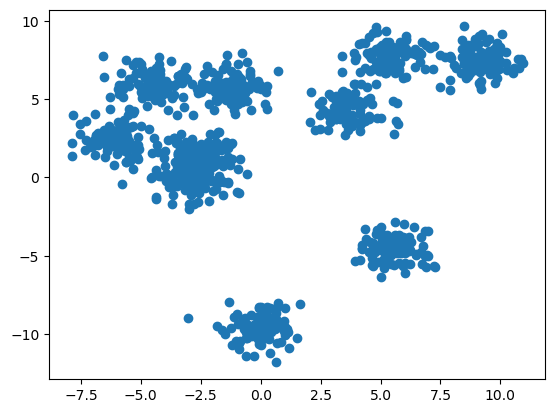

In [2]:
loss = []
plt.scatter(x[:,0],x[:,1])

## 1. PCA & LDA

PCA Algorithm
1. Subtract mean
2. Calculate the covariance matrix
3. Calculate eigenvectors and eigenvalues of the covariance matrix
4. Rank eigenvectors by its corresponding eigenvalues
5. Obtain P (transformation matrix) with its row vectors corresponding to the top k eigenvectors
$$y = P\hat{X}$$

Resources:
- [Reading material #1](https://www.knowledgehut.com/blog/data-science/linear-discriminant-analysis-for-machine-learning)
- [Reading material #2](https://towardsdatascience.com/understanding-high-dimensional-spaces-in-machine-learning-4c5c38930b6a)
- [Coding meterial #1](https://github.com/AmirAli5/Machine-Learning/tree/main/Unsupervised%20Machine%20Learning/3.%20Dimensionality%20Reduction)

In [4]:
class pca:
    def __init__(self, x, n_components = None):
        self.x = x
        self.n_components = n_components
        self.num_features = x.shape[0]
        self.ori_feat = x.shape[1]
        self.cov_mat = None
        self.P = None
        self.y = None

    def cov(self):
        self.cov_mat = np.cov(self.x.T)
        return self.cov_mat
    def standardization(self):
        return self.x - np.mean(self.x, axis=0)
    def reduce_feature(self):
        x_meaned = self.standardization()
        x_cov = self.cov()
        eigen_val, eigen_vec = np.linalg.eig(x_cov)
        sort_index = np.argsort(eigen_val)[::1]

        sorted_eigenval = eigen_val[sort_index]
        sorted_eigenvector = eigen_vec[:,sort_index]

        self.P = sorted_eigenvector[:,0:self.n_components]
        self.y = np.dot(self.P.T, x_meaned.T).T
        return self.y

pca_1 = pca(x, 10)
new_x = pca_1.reduce_feature()
print(f'The input x has shape {x.shape}, and the transformed x has shape {new_x.shape}')
print(f'The sum of the input covariance matrix is {round(np.sum(pca_1.cov_mat), 5)}.')
print(f'The sum of the transformed covariance matrix is {round(np.sum(np.cov(new_x.T)).real, 5)}.')

The input x has shape (1000, 2), and the transformed x has shape (1000, 2)
The sum of the input covariance matrix is 59.34134.
The sum of the transformed covariance matrix is 51.98034.


## 2. K-Means

Loss function of k-means:
$$J = \sum_{i=1}^n \sum_{j = 1}^K r_{ik} ||x_i-\mu_k||_2^2$$
where $\mu$ is centroids, $x$ is the datapoints. $r_{ik} = 1$ if $x_i$ belongs to $\mu_k$, otherwise $r_{ik} = 0$. 

Resources:
- [Reading material #1](https://www.analyticsvidhya.com/blog/2020/10/a-simple-explanation-of-k-means-clustering/)

In [6]:
def k_means(x, k = 2 , epochs = 600):
    # 1. Randomly initialize k centroids
    np.random.seed(2024)
    clusters = []

    # ==============================================================
    # "you need to randomly initialize k centroids using x"
    cluster_center = x[np.random.randint(0,x.shape[0],k),:]

    # ==============================================================

    for i in range(k):
        clusters.append([])

    # 2. Training
    for _ in range(epochs):
        new_clusters_center = np.zeros((k, x.shape[1]))
        for i in range(k):
            clusters[i]=[]

        ## a. E-step: finding points to the nearest centroid, assigning to corresponding clusters
        ## Calculate the distance from all points to the k cluster centers
        for i in range(x.shape[0]):
            xi = x[i]

            # ==============================================================
            # "Calculate the distance of xi with each centroid using norm2"
            distances = np.linalg.norm(xi-cluster_center, axis=1)

            # Assign points to the closest cluster
            # "Find out the nearest centroid to xi"
            # Returns the index of the nearest centriod to this datapoint
            c = np.argmin(distances)

            # ==============================================================
            clusters[c].append(i) # Append this datapoint to this cluster

        ## b. M-step: recalculate the location of the centroid using the mean of the clusters
        for i in range(k):
            # ==============================================================
            # "You need to calculate the position of the new centroids"
            if len(clusters[i]) == 0:
                new_clusters_center[i] = x[np.random.randint(0,x.shape[0]), :]
            else:
                new_clusters_center[i] = np.sum(x[clusters[i]],axis=0) / len(clusters[i])

            # ==============================================================

        # c. If the centroid did not change, the algorithm should be stopped, otherwise continue.
        if np.all(new_clusters_center == cluster_center):
            return clusters, new_clusters_center

        # d. update the centroid
        loss.append(abs(np.sum(new_clusters_center - cluster_center)))
        # ==============================================================
        cluster_center = new_clusters_center

        # ==============================================================
    return clusters, cluster_center

clusters, cluster_center = k_means(x, k)


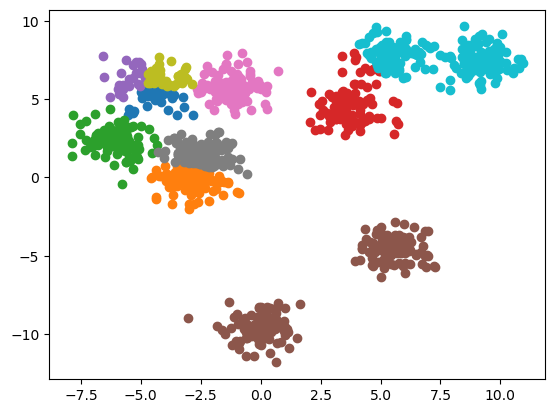

In [7]:
np.random.seed(seed)
plot(x, k, clusters)

## 3. Kernel KMeans
Resources:
- [Reading material #1](https://programmathically.com/what-is-a-kernel-in-machine-learning/)

RBF-kernel:
$$kernel\_x(\textbf{x}_i, \textbf{x}_j) = exp(\frac{-||\textbf{x}_i, \textbf{x}_j||_2^2}{2\sigma^2})$$
The hyper-parameter can be empirically set to:
$$2\sigma^2 = \frac{1}{N^2}\sum_{i=1}^N\sum_{j=1}^N||\textbf{x}_i-\textbf{x}_j||_2^2$$

In [8]:
def cal_RBF(x):
    ## implement RBF method
    n = x.shape[0]
    # ==============================================================
    # "You need to initialize k"
    kernel_x = np.zeros((n,n))

    # ==============================================================
    sigma = 0

    for i in range(n):
        for j in range(n):
            # ==============================================================
            # "You need to implement sigma here"
            sigma += np.linalg.norm(x[i] - x[j]) ** 2

            # ==============================================================
    sigma = 2 * sigma/(n**2)
    # gamma = 1/(2*sigma)

    for i in range(n):
        for j in range(n):
            # ==============================================================
            # "You need to implement kernel x here"
            kernel_x[i, j] = np.exp((-np.linalg.norm(x[i]-x[j]))**2/sigma)
            #kernel_x[i, j] = np.exp(-gamma * np.linalg.norm(x[i]-x[j]))**2)

            # ==============================================================
    #kernel_x = k
    return kernel_x
kernel_x = cal_RBF(x)
clusters, cluster_center = k_means(kernel_x, k)

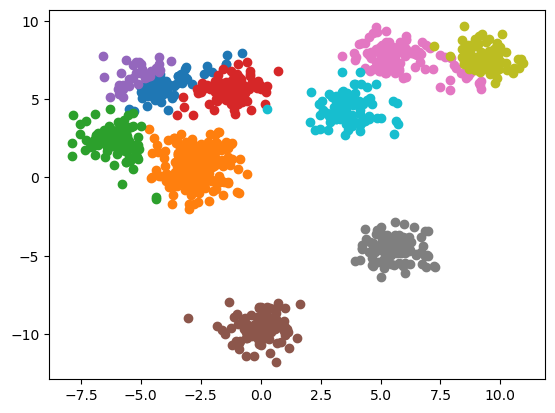

In [9]:
plot(x, k,clusters)

## 4. Ensemble Methods
Resources:
- [Reading material #1](https://towardsdatascience.com/understanding-the-bias-variance-tradeoff-165e6942b229)
- [Reading material #2](https://machinelearningmastery.com/tour-of-ensemble-learning-algorithms/)
- [Reading material #3](https://machinelearningmastery.com/a-gentle-introduction-to-the-bootstrap-method/)
- [Reading material #4](https://towardsai.net/p/machine-learning/differences-between-ai-and-machine-learning-1255b182fc6)

### a. Classification
- [Material #1](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html)

In [10]:
# Import necessary libraries
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Create a synthetic dataset for demonstration
X, y = make_classification(n_samples=1000, n_features=20, random_state=42)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an AdaBoostClassifier
ada_classifier = AdaBoostClassifier(n_estimators=50, random_state=42)

# Fit the classifier to the training data
ada_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = ada_classifier.predict(X_test)

# Evaluate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')


Accuracy: 0.87


/opt/anaconda3/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


### b. Regression
- [Decision Tree Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html)
- [AdaBoost Regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostRegressor.html)


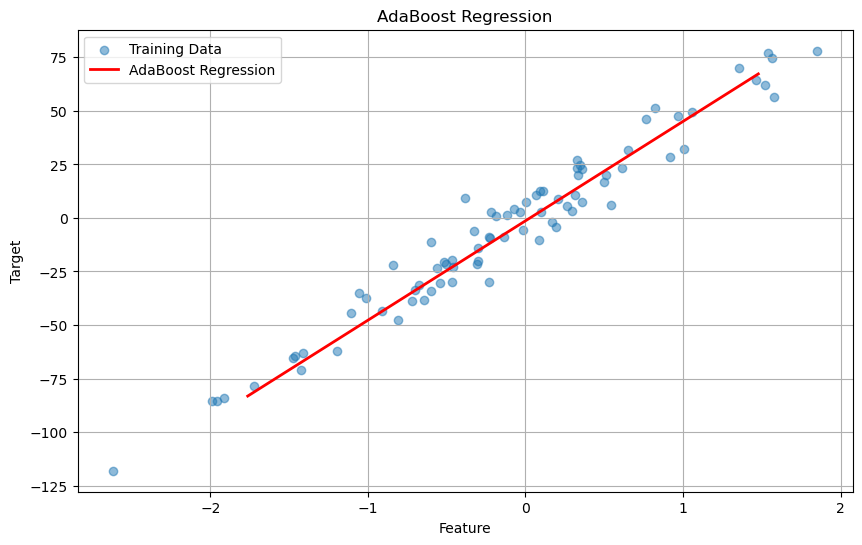

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor  # Corrected import
from sklearn.datasets import make_regression

# Generate synthetic regression data
X, y = make_regression(n_samples=100, n_features=1, noise=10, random_state=42)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create an AdaBoostRegressor model
base_regressor = DecisionTreeRegressor(max_depth=3)
ada_boost_regressor = AdaBoostRegressor(base_regressor, n_estimators=50, random_state=42)

# Train the AdaBoostRegressor model
ada_boost_regressor.fit(X_train, y_train)

# Make predictions on the test data
y_pred = ada_boost_regressor.predict(np.sort((X_test.reshape(1, -1)))[0].reshape(-1,1))

# Visualize the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X_train, y_train, label="Training Data", alpha=0.5)
# plt.scatter(X_test, y_test, label="Testing Data", alpha=0.5)

plt.plot([np.sort((X_test.reshape(1, -1)))[0].reshape(-1,1)[0], np.sort((X_test.reshape(1, -1)))[0].reshape(-1,1)[-1]], [y_pred[0], y_pred[-1]], color='red', linewidth=2, label="AdaBoost Regression")
plt.title("AdaBoost Regression")
plt.xlabel("Feature")
plt.ylabel("Target")
plt.legend()
plt.grid(True)
plt.show()


### c. Random Forest
- [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)

Accuracy: 1.00


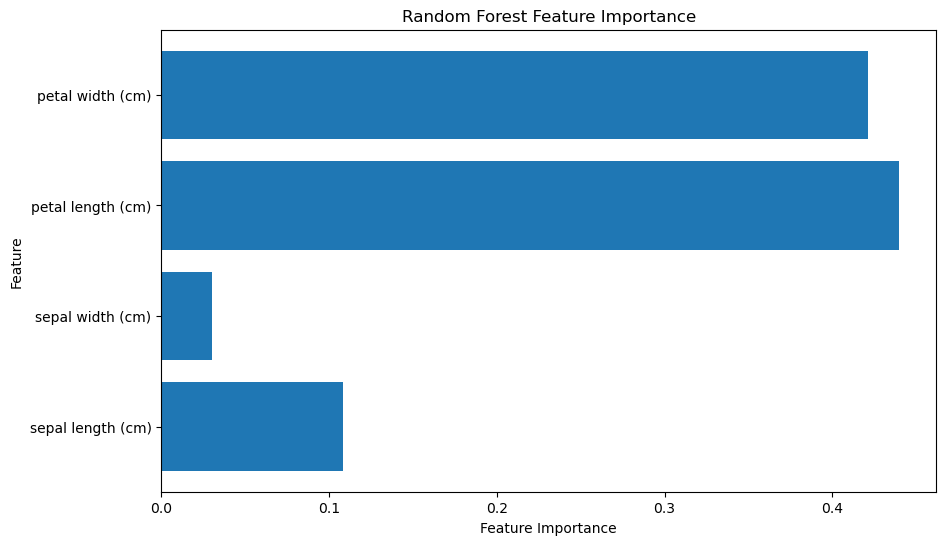

In [12]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load the Iris dataset as an example
iris = load_iris()
X = iris.data
y = iris.target

# Split the dataset into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a Random Forest Classifier with 100 trees
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Fit the model to the training data
rf_classifier.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Feature importance
feature_importance = rf_classifier.feature_importances_
feature_names = iris.feature_names

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(range(len(feature_importance)), feature_importance, align="center")
plt.yticks(range(len(feature_importance)), feature_names)
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.title("Random Forest Feature Importance")
plt.show()


## 5. Additional Resources:
- https://neptune.ai/blog/ensemble-learning-guide
- https://www.geeksforgeeks.org/ensemble-methods-in-python/
- https://www.datacamp.com/tutorial/ensemble-learning-python
- https://scikit-learn.org/stable/modules/ensemble.html
- https://machinelearningmastery.com/ensemble-machine-learning-algorithms-python-scikit-learn/
- https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/